In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from fastai.tabular.all import *
from sklearn.metrics import confusion_matrix
path = Path('playground-series-s4e2')
pd.options.display.float_format = '{:.2f}'.format
set_seed(42)
import zipfile,kaggle
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)

playground-series-s4e2.zip: Skipping, found more recently modified local copy (use --force to force download)


## Initialise
download data from kaggle

In [ ]:
pf_train = pd.read_csv(path/'train.csv')
#pf_train = pd.read_csv(path/'uci.csv')
pf_test = pd.read_csv(path/'test.csv')
pf_submit = pd.read_csv(path/'sample_submission.csv')

In [ ]:
def add_features(df):
    df['LogWeight'] = np.log1p(df['Weight'])
    
add_features(pf_train)

In [ ]:
def create_dataloader(df):
    df = df.drop(columns=['Weight','id'])
    cont, cat = cont_cat_split(df,1, dep_var="NObeyesdad")
    return TabularPandas(
        df, splits= RandomSplitter(seed=42)(df),
        procs = [Categorify, FillMissing, Normalize],
        cat_names=cat,
        cont_names=cont,
        y_names="NObeyesdad", y_block = CategoryBlock(),
        ).dataloaders(path=".")

SuggestedLRs(slide=0.00015848931798245758, valley=9.120108734350652e-05)

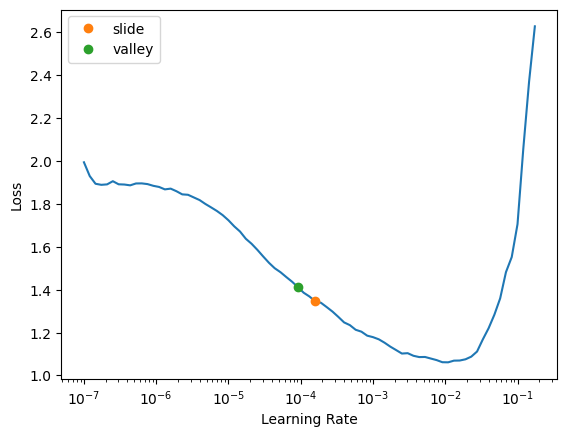

In [ ]:
dls = create_dataloader(pf_train)
learn = tabular_learner(dls, metrics=accuracy, layers=[5000,2500])
learn.lr_find(suggest_funcs=(slide, valley))

## baseline model

Validation Accuracy: 0.874729 Submission Accuracy: 0.87752

In [ ]:
learn.fit(16, lr=0.0005)

epoch,train_loss,valid_loss,accuracy,time
0,1.017016,0.619730,0.786730,00:00
1,0.630458,0.363195,0.876777,00:00
2,0.454729,0.250141,0.912322,00:00
3,0.368955,0.234570,0.924171,00:00
4,0.330294,0.228543,0.914692,00:00
5,0.281773,0.205173,0.928910,00:00
6,0.256204,0.238587,0.921801,00:00
7,0.238723,0.200222,0.928910,00:00
8,0.207311,0.171155,0.936019,00:00
9,0.210002,0.230667,0.909953,00:00


In [ ]:
dls = create_dataloader(pf_train)
learn.dls = dls
learn.fine_tune(16)

epoch,train_loss,valid_loss,accuracy,time
0,0.661140,0.632495,0.793785,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.434931,0.374064,0.865093,00:06
1,0.450539,0.396113,0.858829,00:06
2,0.482441,0.398916,0.863888,00:06
3,0.467733,0.424667,0.854011,00:06
4,0.459985,0.398473,0.860516,00:06
5,0.421138,0.451660,0.840039,00:06
6,0.440074,0.409753,0.853288,00:06
7,0.423751,0.433587,0.849916,00:06
8,0.364386,0.413774,0.853047,00:06
9,0.360497,0.384943,0.872802,00:06


In [ ]:
tst_dl = learn.dls.test_dl(pf_test)
len(pf_test)
preds,targets,decoded = learn.get_preds(dl=tst_dl,with_decoded=True)
preds

tensor([[2.0226e-07, 1.5164e-05, 6.9192e-04,  ..., 5.4945e-06, 1.1516e-03,
         8.1532e-04],
        [6.8852e-04, 1.9084e-02, 5.0338e-01,  ..., 6.3983e-05, 4.6557e-01,
         1.1102e-02],
        [2.1415e-06, 1.1705e-06, 6.3211e-05,  ..., 9.9993e-01, 3.4750e-06,
         9.5637e-07],
        ...,
        [4.8471e-01, 4.0415e-01, 1.2450e-03,  ..., 5.6293e-05, 1.0677e-01,
         3.0364e-03],
        [1.3396e-02, 1.4828e-01, 3.7313e-01,  ..., 2.1470e-05, 6.9590e-02,
         3.9527e-01],
        [2.2903e-05, 3.4148e-04, 2.1584e-03,  ..., 8.4025e-06, 9.1794e-04,
         8.7212e-03]])

['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']

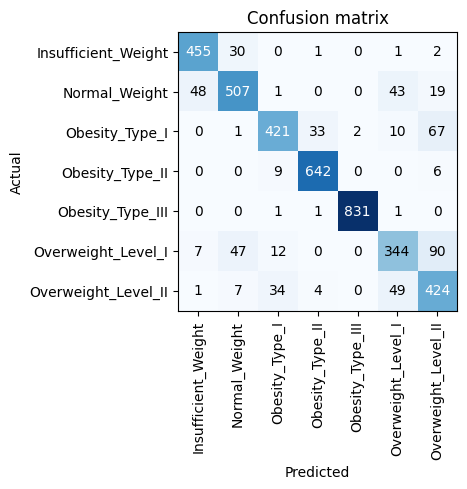

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
v_preds, v_y = learn.get_preds(dl=learn.dls.valid)
learn.dls.valid.vocab

<Axes: xlabel='NObeyesdad'>

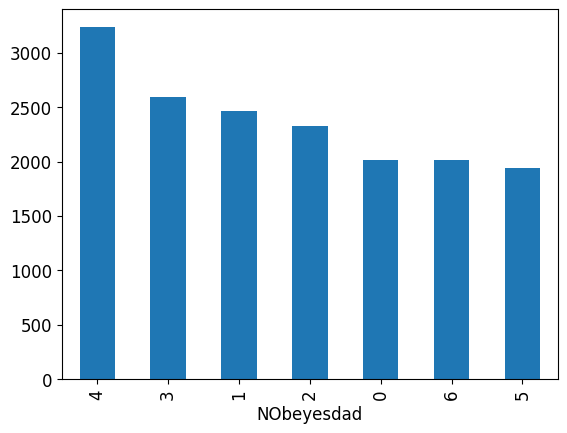

In [ ]:
learn.dls.train.y['NObeyesdad'].value_counts().plot(kind='line')

<Axes: xlabel='NObeyesdad'>

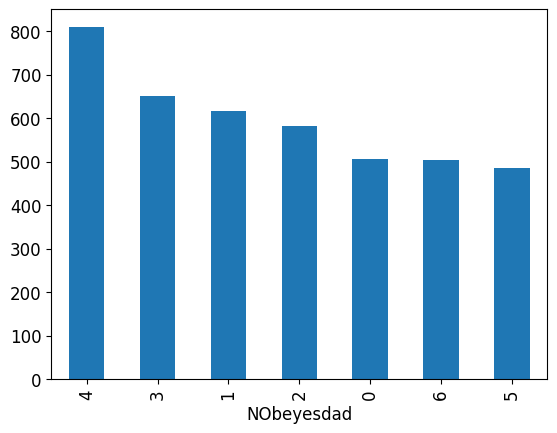

In [ ]:
learn.dls.valid.y.value_counts().plot(kind='bar')

## second attempt - ensemble

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[5000,2500], cbs=WandbCallback())
    with learn.no_bar(): learn.fit(11, lr=0.0005)
    return learn.get_preds(dl=tst_dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]
ens_preds = torch.stack(learns).mean(0)
ens_preds

[0, 0.5775935649871826, 0.4861854314804077, 0.8166706562042236, '00:06']
[1, 0.4913997948169708, 0.4324672818183899, 0.8484702706336975, '00:06']
[2, 0.46715936064720154, 0.44818350672721863, 0.8484702706336975, '00:06']
[3, 0.46564188599586487, 0.4057254195213318, 0.8537701964378357, '00:06']
[4, 0.4327734410762787, 0.3740197420120239, 0.8703926801681519, '00:06']
[5, 0.4364193379878998, 0.3818459212779999, 0.8713563084602356, '00:06']
[6, 0.4286254942417145, 0.38279959559440613, 0.8675017952919006, '00:06']
[7, 0.42209306359291077, 0.36984285712242126, 0.8677427172660828, '00:06']
[8, 0.391170471906662, 0.3697650730609894, 0.8713563084602356, '00:06']
[9, 0.3908531069755554, 0.3824230432510376, 0.8682245016098022, '00:06']
[10, 0.3857397735118866, 0.3729053735733032, 0.8723199367523193, '00:06']


[0, 0.5807120203971863, 0.44300317764282227, 0.8357022404670715, '00:06']
[1, 0.5007785558700562, 0.4203546941280365, 0.8525656461715698, '00:06']
[2, 0.4471232295036316, 0.386211633682251, 0.8670200109481812, '00:06']
[3, 0.45794767141342163, 0.38998204469680786, 0.8634064197540283, '00:06']
[4, 0.4536328613758087, 0.37455031275749207, 0.8711153864860535, '00:06']
[5, 0.44308167695999146, 0.3741070032119751, 0.870633602142334, '00:06']
[6, 0.4125370979309082, 0.36531975865364075, 0.8785834908485413, '00:06']
[7, 0.4126831889152527, 0.40769487619400024, 0.8564201593399048, '00:06']
[8, 0.40061575174331665, 0.3843582272529602, 0.8677427172660828, '00:06']
[9, 0.3842773139476776, 0.3780982494354248, 0.8643700480461121, '00:06']
[10, 0.3788657486438751, 0.3686677813529968, 0.8744880557060242, '00:06']


[0, 0.5598577857017517, 0.47005483508110046, 0.831125020980835, '00:06']
[1, 0.521826982498169, 0.4088040292263031, 0.8520838618278503, '00:06']
[2, 0.4694017171859741, 0.4322105646133423, 0.8424475789070129, '00:06']
[3, 0.4660051167011261, 0.38685885071754456, 0.8672608733177185, '00:06']
[4, 0.44780904054641724, 0.4211950898170471, 0.8506383895874023, '00:06']
[5, 0.44427594542503357, 0.39360418915748596, 0.8566610217094421, '00:06']
[6, 0.45255377888679504, 0.4584314823150635, 0.8417248725891113, '00:06']
[7, 0.41963377594947815, 0.413557767868042, 0.8542519807815552, '00:06']
[8, 0.4033788740634918, 0.4063560962677002, 0.8537701964378357, '00:06']
[9, 0.43371355533599854, 0.4952635169029236, 0.8200433850288391, '00:06']
[10, 0.8454539179801941, 1.2443972826004028, 0.6314141154289246, '00:06']


[0, 0.6108018159866333, 0.527366578578949, 0.8012527227401733, '00:06']
[1, 0.5304014086723328, 0.43973812460899353, 0.8378704190254211, '00:06']
[2, 0.4780002236366272, 0.4218621253967285, 0.8475066423416138, '00:06']
[3, 0.4649752676486969, 0.41198107600212097, 0.8511202335357666, '00:06']
[4, 0.4762108623981476, 0.42734983563423157, 0.8496747612953186, '00:06']
[5, 0.446995347738266, 0.4462251663208008, 0.8393158316612244, '00:06']
[6, 0.46603426337242126, 0.5314552187919617, 0.8142616152763367, '00:06']
[7, 1.0238590240478516, 1.0702252388000488, 0.6379185914993286, '00:06']
[8, 0.46902260184288025, 0.41798582673072815, 0.848952054977417, '00:06']
[9, 0.4355092942714691, 0.3927021026611328, 0.8612382411956787, '00:06']
[10, 0.4083844721317291, 0.40692877769470215, 0.8547338247299194, '00:06']


[0, 0.5747424364089966, 0.5194013714790344, 0.7986027598381042, '00:06']
[1, 0.5307773947715759, 0.43262165784835815, 0.8424475789070129, '00:06']
[2, 0.4769729673862457, 0.4144265651702881, 0.851361095905304, '00:06']
[3, 0.4661833941936493, 0.39433178305625916, 0.8636473417282104, '00:06']
[4, 0.452789843082428, 0.3923255503177643, 0.8619609475135803, '00:06']
[5, 0.4538993239402771, 0.4013828635215759, 0.855456531047821, '00:06']
[6, 0.42865803837776184, 0.38844218850135803, 0.8672608733177185, '00:06']
[7, 0.4165303111076355, 0.3953399062156677, 0.8600337505340576, '00:06']
[8, 0.3967440724372864, 0.410462886095047, 0.8516020178794861, '00:06']
[9, 0.4192163646221161, 0.40272170305252075, 0.8576246500015259, '00:06']
[10, 0.4045695960521698, 0.45507827401161194, 0.8393158316612244, '00:06']


tensor([[7.2844e-04, 6.1975e-04, 3.5554e-03,  ..., 5.5923e-04, 3.6841e-05, 3.1191e-03],
        [4.3480e-05, 1.1308e-02, 3.8519e-01,  ..., 3.3327e-04, 5.8089e-01, 2.2152e-02],
        [1.2409e-04, 2.6767e-05, 3.3423e-05,  ..., 9.9979e-01, 1.6565e-05, 3.1619e-06],
        ...,
        [7.2023e-01, 2.7076e-01, 6.2969e-05,  ..., 1.8326e-03, 6.4828e-03, 3.5509e-05],
        [1.5118e-01, 6.6860e-01, 9.9736e-02,  ..., 2.3852e-04, 2.7103e-02, 5.2147e-02],
        [3.5480e-04, 4.3857e-04, 2.1749e-03,  ..., 6.2083e-04, 1.4987e-04, 2.4105e-03]])

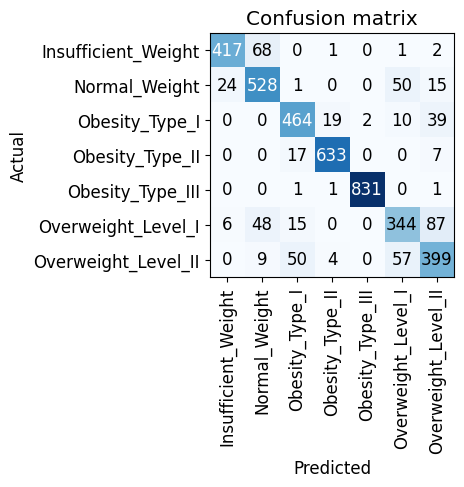

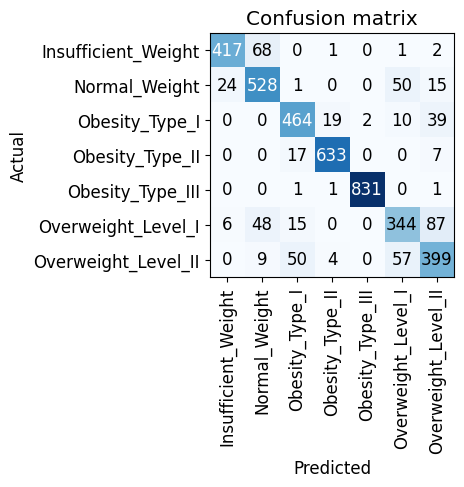

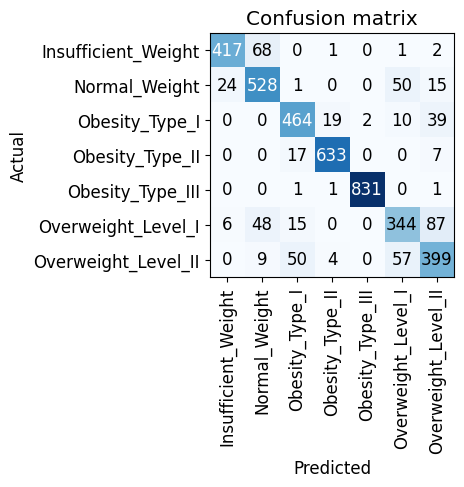

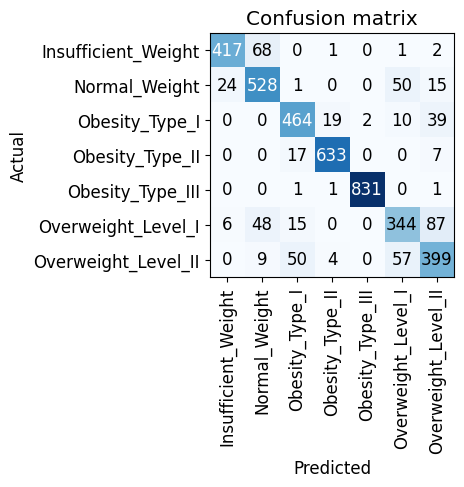

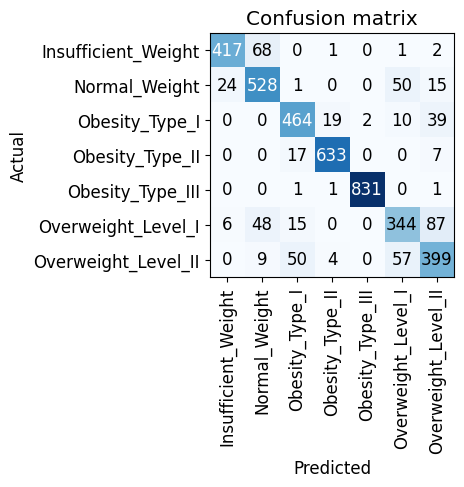

In [ ]:
for l in learns: 
    ClassificationInterpretation.from_learner(learn).plot_confusion_matrix()

In [ ]:
decoded = np.argmax(ens_preds,axis=1)

## Decision Tree experiments

In [ ]:
#pf_train = pf_train.drop(columns=['LogWeight'])
cont, cat = cont_cat_split(pf_train,1, dep_var="NObeyesdad")
spliter = RandomSplitter(valid_pct=0.2, seed=42)
to = TabularPandas(pf_train,[Categorify,FillMissing],cat,cont,y_names="NObeyesdad",splits=spliter(pf_train))


In [ ]:
to.show(3)
to.items.head(3)

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,LogWeight,NObeyesdad
15584,Male,yes,yes,Sometimes,no,no,no,Public_Transportation,15584,26.95,1.65,101.07,2.92,2.10,1.99,1.81,0.00,4.63,Obesity_Type_II
6294,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,6294,21.28,1.72,133.74,3.00,3.00,2.85,1.50,0.72,4.90,Obesity_Type_III
15761,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,15761,18.00,1.74,51.46,1.89,3.00,1.96,0.87,1.89,3.96,Insufficient_Weight


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,LogWeight
15584,15584,2,26.95,1.65,101.07,2,2,2.92,2.10,3,1,1.99,1,1.81,0.00,3,4,3,4.63
6294,6294,1,21.28,1.72,133.74,2,2,3.00,3.00,3,1,2.85,1,1.50,0.72,2,4,4,4.90
15761,15761,2,18.00,1.74,51.46,2,2,1.89,3.00,3,1,1.96,1,0.87,1.89,2,4,0,3.96


In [ ]:
from sklearn.tree import DecisionTreeRegressor
xs,y=to.train.xs,to.train.y
valid_xs,valid_y=to.valid.xs,to.valid.y
m = DecisionTreeRegressor(min_samples_leaf=75)
m.fit(xs,y)


DecisionTreeRegressor(min_samples_leaf=75)

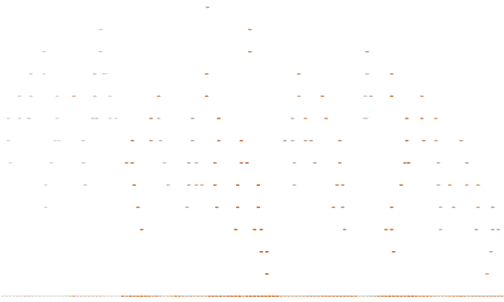

In [ ]:
from fastbook import *
draw_tree(m,xs,size=7,leaves_parallel=True, precision=2)

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()),6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs),y)

In [ ]:
m_rmse(m,xs,y),m_rmse(m,valid_xs,valid_y),m.get_n_leaves()

(0.892871, 0.929998, 134)

In [ ]:

dls = to.dataloaders()
test_dl = dls.test_dl(pf_test)
dt_preds = m.predict(test_dl.dataset.xs)


array([2.98666667, 4.32954545, 3.97744361, ..., 0.01333333, 1.33870968, 2.98666667])

In [ ]:
dt_val_preds = m.predict(valid_xs)
print(vocab)
confusion_matrix(valid_y.values, np.round(dt_val_preds).astype(int))

['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']


array([[449,  36,   0,   3,   0,   1,   0],
       [ 43, 423,  56,  42,  39,  14,   1],
       [  0,   0, 331, 107,  64,  19,  13],
       [  0,   0,  24, 612,  18,   2,   1],
       [  0,   0,   0,   3, 831,   0,   0],
       [  7,  13,  30,  39,  97, 271,  43],
       [  0,   2,  13,  40,  67, 129, 268]])

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def rf(xs, y, n_estimators=40, max_samples=16607,
        max_features="sqrt", min_samples_leaf=5, **kwards):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs,y)
rfm = rf(xs, y)
m_rmse(rfm,xs,y),m_rmse(rfm,valid_xs,valid_y)

(0.669187, 0.832034)

In [ ]:
rf_preds = np.stack([t.predict(valid_xs.values) for t in rfm.estimators_])
rf_preds = rf_preds.mean(0)
r_mse(preds.mean(0),valid_y)

0.834188

In [ ]:
rf_preds = rfm.predict(test_dl.dataset.xs)

In [ ]:
rf_valid_preds = m.predict(valid_xs)
print(vocab)
confusion_matrix(valid_y.values, np.round(rf_valid_preds).astype(int))

['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']


array([[449,  36,   0,   3,   0,   1,   0],
       [ 43, 423,  56,  42,  39,  14,   1],
       [  0,   0, 331, 107,  64,  19,  13],
       [  0,   0,  24, 612,  18,   2,   1],
       [  0,   0,   0,   3, 831,   0,   0],
       [  7,  13,  30,  39,  97, 271,  43],
       [  0,   2,  13,  40,  67, 129, 268]])

[<matplotlib.lines.Line2D>]

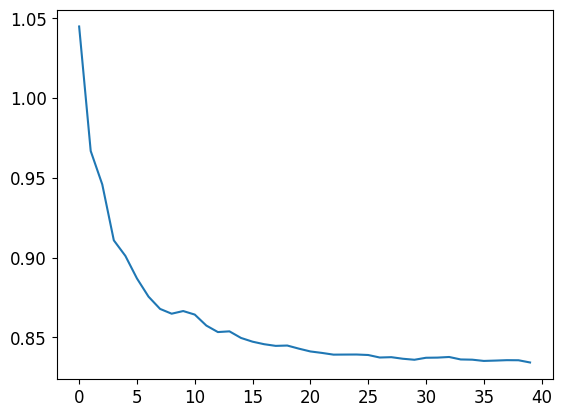

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

In [ ]:
r_mse(m.oob_prediction_,y)
preds.shape
preds_std = preds.std(0)
preds_std[:5]

array([0.04667296, 0.67695288, 0.39354254, 0.00271522, 0.56784587])

<Axes: ylabel='cols'>

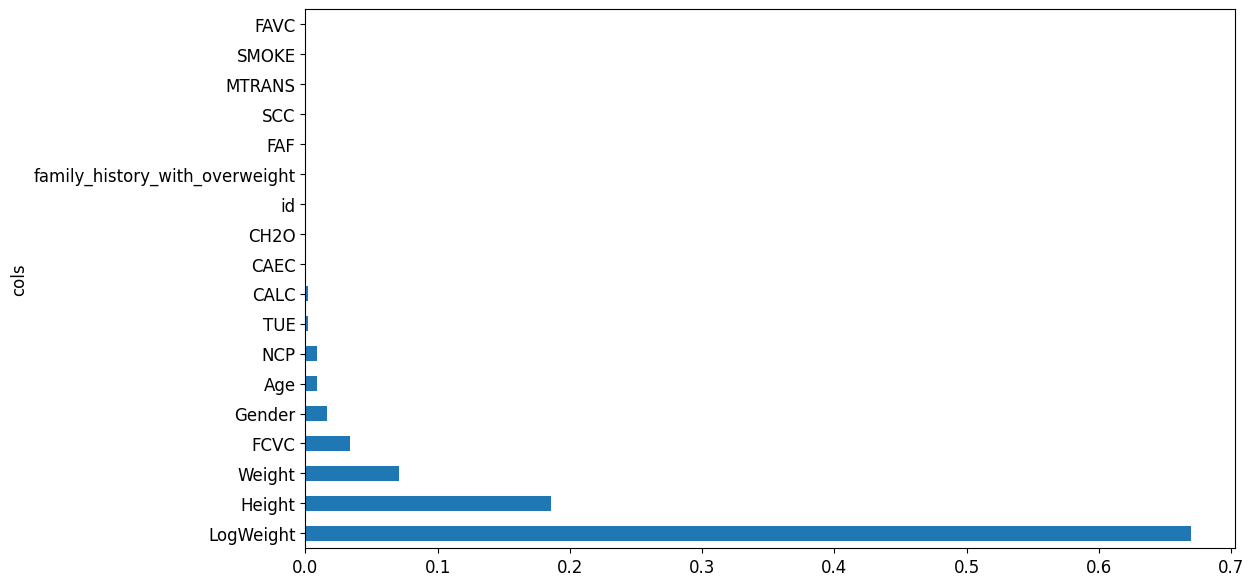

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns,'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(m, xs)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi)

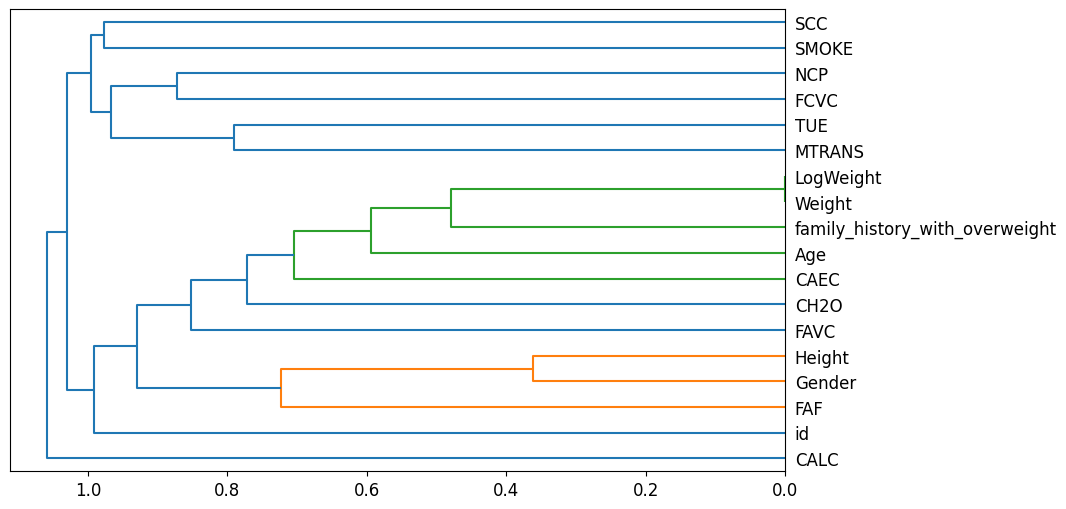

In [ ]:
cluster_columns(xs)

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=75,
                              max_samples=16000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [ ]:
get_oob(xs)

0.779094692603369

In [ ]:
{c:get_oob(xs.drop(c,axis=1)) for c in ('LogWeight','Weight','Height','Gender','family_history_with_overweight','Age','CAEC','CH2O','TUE','MTRANS')}


{'LogWeight': 0.7545606128683375,
 'Weight': 0.7569677885729349,
 'Height': 0.7266793145625081,
 'Gender': 0.7682693489063032,
 'family_history_with_overweight': 0.7752166669636453,
 'Age': 0.7753033090316663,
 'CAEC': 0.775798531599551,
 'CH2O': 0.7779307596104987,
 'TUE': 0.7755312592799928,
 'MTRANS': 0.7766868847611138}

In [ ]:
to_drop = ['SCC','SMOKE','NCP','FCVC','TUE','CALC']
get_oob(xs.drop(to_drop, axis=1))


0.773730832356033

In [ ]:
xs_final = xs.drop(to_drop, axis=1)
valid_final = valid_xs.drop(to_drop, axis=1)

In [ ]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_final, valid_y)

(0.876212, 0.891736)

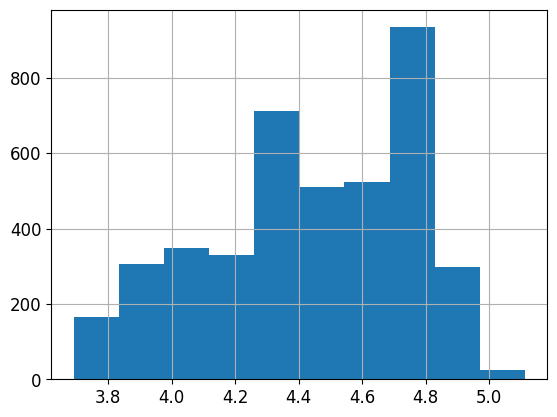

In [ ]:
p = valid_final['LogWeight'].hist()


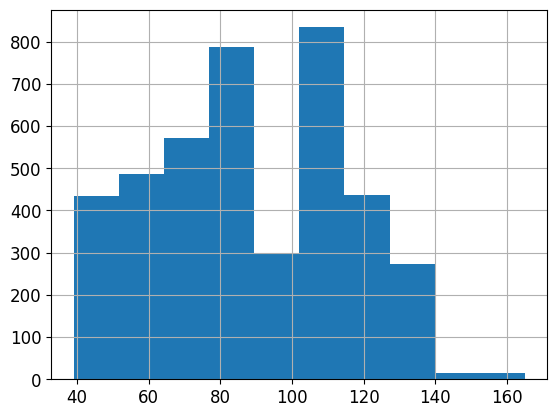

In [ ]:
q = valid_final['Weight'].hist()

<sklearn.inspection._plot.partial_dependence.PartialDependenceDisplay>

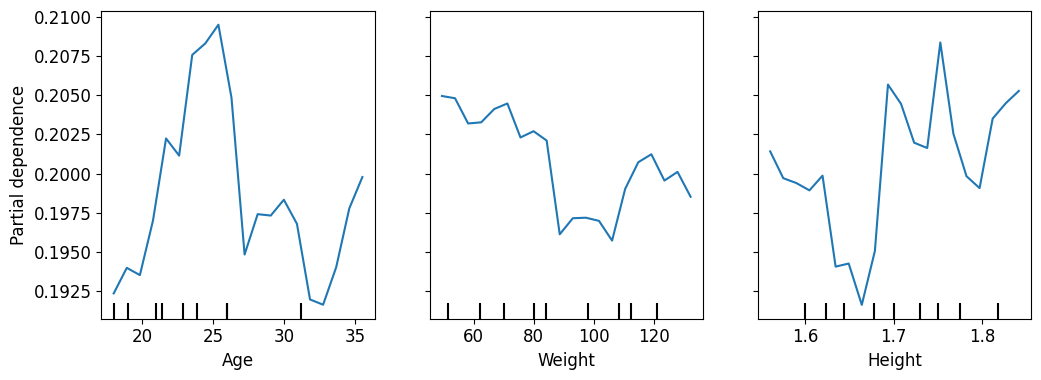

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(12,4))
PartialDependenceDisplay.from_estimator(m, valid_final, ['Age','Weight','Height'],
                        grid_resolution=20,ax=ax)

In [ ]:
df_dom = pd.concat([xs_final, valid_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_final))
m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)

,cols,imp
5,id,0.24
7,Height,0.16
6,Age,0.14
8,Weight,0.11
11,LogWeight,0.11
10,FAF,0.10
9,CH2O,0.10
0,Gender,0.01
2,FAVC,0.01
4,MTRANS,0.01


## XGBoost

In [ ]:
to.vocab

['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']

In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
kfold = StratifiedKFold(10, shuffle=True, random_state=42)

15584    3
6294     4
15761    0
10282    5
11277    3
        ..
10207    2
532      0
18996    3
11708    1
2815     1
Name: NObeyesdad, Length: 16607, dtype: int8

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42,max_depth= 10, 
               n_estimators=1224, 
               gamma=0.8323134488556143, 
               reg_alpha=0.9211957174104992, 
               reg_lambda=0.8522905506401445, 
               min_child_weight=4, 
               subsample= 0.9232723357974977, 
               colsample_bytree= 0.4785000546841373, 
               learning_rate= 0.06435693511798936)
xgb_model = xgb_model.fit(learn.dls.train.xs, learn.dls.train.y)
xgb_preds =cross_val_predict(xgb_model,learn.dls.train.xs,learn.dls.train.y,cv=kfold)
print(confusion_matrix(learn.dls.train.y.values, np.round(xgb_preds).astype(int)))
accuracy_score(tensor(learn.dls.train.y.values.astype(int)), tensor(np.round(xgb_preds).astype(int)))

[[1613  274   44    8    9   52   34]
 [ 174 1892   99   11    0  172  116]
 [  37  158 1747  101   13  119  201]
 [   3   25   58 2430    1   15   59]
 [   2    9    0    1 3199    1    0]
 [  99  375  223   37    7  963  223]
 [  58  212  250  129    4  147 1203]]


0.7856325645812007

In [ ]:
test_dl = learn.dls.test_dl(pf_test)
xgb_preds = xgb_model.predict_proba(test_dl.xs)

In [ ]:
xgb_valid_preds = xgb_model.predict_proba(learn.dls.valid.xs)
print(confusion_matrix(learn.dls.valid.y.values, np.argmax(xgb_valid_preds,axis=1)))
accuracy_score(tensor(learn.dls.valid.y.values.astype(int)), tensor(np.argmax(xgb_valid_preds,axis=1).astype(int)))

[[461  24   0   1   0   2   1]
 [ 25 556   0   0   0  31   6]
 [  0   1 477  16   1   7  32]
 [  0   0  12 639   0   0   6]
 [  0   0   1   2 831   0   0]
 [  8  38  11   0   0 383  60]
 [  0   8  41   4   0  43 423]]


0.9082148879788002

## LGBM

In [ ]:
import lightgbm as lgbm
lgbm_model = lgbm.LGBMClassifier(random_state=42,max_depth=10,num_class=7,
                                 min_child_samples=26,num_leaves=31,objective='multiclass_ova',metric='multi_logloss',boosting_type='gbdt',
                                    verbosity=-1,                    # Verbosity level (-1 for silent)
                                    learning_rate=0.030962211546832760,  # Learning rate for gradient boosting
                                    n_estimators=500,                # Number of boosting iterations
                                    lambda_l1=0.009667446568254372,  # L1 regularization term
                                    lambda_l2=0.04018641437301800,   # L2 regularization term
                                    colsample_bytree=0.40977129346872643,  # Fraction of features to consider for each tree
                                    subsample=0.9535797422450176 )           # Minimum number of data needed in a leaf)
#lgbm_model = lgbm_model.fit(learn.dls.train.xs, learn.dls.train.y)
lgbm_preds =cross_val_predict(lgbm_model,learn.dls.train.xs,learn.dls.train.y,cv=kfold)
print(confusion_matrix(learn.dls.train.y.values, np.round(lgbm_preds).astype(int)))
accuracy_score(tensor(learn.dls.train.y.values.astype(int)), tensor(np.round(lgbm_preds).astype(int)))


[[3134  113    1    1    0    8    3]
 [ 121 3626    1    0    0  110   32]
 [   3    2 3423   69   11   50  138]
 [   0    0   48 4204    0    1   10]
 [   1    0    4    4 5327    2    0]
 [  15  167   37    0    0 2354  238]
 [   1   37  139   13    0  160 2909]]


0.9419240487234605

In [ ]:
lgbm_model = lgbm_model.fit(learn.dls.train.xs, learn.dls.train.y)
lgbm_preds = lgbm_model.predict_proba(test_dl.dataset.xs)
lgbm_preds

array([[2.78813895e-05, 1.30421100e-06, 4.31801335e-04, ...,
        1.71837284e-06, 4.25807462e-05, 7.33516162e-05],
       [2.18528921e-05, 1.65607289e-02, 4.55774993e-03, ...,
        5.68503718e-07, 9.70284950e-01, 1.41787557e-02],
       [1.03945117e-05, 4.44161091e-06, 5.72041037e-04, ...,
        9.99992443e-01, 2.75784111e-05, 1.37992608e-05],
       ...,
       [9.96838071e-01, 6.13507129e-04, 6.55699968e-05, ...,
        1.17009076e-06, 5.21858975e-04, 7.71938681e-05],
       [6.20575346e-02, 8.51165905e-01, 1.07184406e-03, ...,
        4.72799694e-07, 2.30318915e-03, 8.82910907e-05],
       [2.80692237e-05, 2.73883409e-06, 6.04936923e-04, ...,
        1.32524931e-06, 3.69125465e-05, 8.67934529e-05]])

In [ ]:
lgbm_valid_preds = lgbm_model.predict_proba(learn.dls.valid.xs)
print(confusion_matrix(learn.dls.valid.y.values, np.argmax(lgbm_valid_preds,axis=1)))
accuracy_score(tensor(learn.dls.valid.y.values.astype(int)), tensor(np.argmax(lgbm_valid_preds,axis=1).astype(int)))

[[ 833   32    0    0    0    2    0]
 [  32  921    2    0    0   27    1]
 [   0    1  883   18    0    5   38]
 [   0    0   14 1048    0    0    4]
 [   0    1    1    0 1328    0    0]
 [   5   48   12    0    0  558   60]
 [   0    1   24    3    0   29  698]]


0.945693166390104

In [ ]:
accuracy_score(tensor(learn.dls.valid.y.values.astype(int)), tensor(np.argmax((lgbm_valid_preds+xgb_valid_preds)/2,axis=1).astype(int)))

ValueError: operands could not be broadcast together with shapes (6629,7) (4151,7) 

## hyper param tuning

In [ ]:
import optuna
from optuna.integration import FastAIPruningCallback

def objective(trial):
    learn = tabular_learner(dls, metrics=accuracy, layers=[5000,2500])
    with learn.no_bar():
        with learn.no_logging():
            learn.fit(trial.suggest_int("epochs",5,15), lr=trial.suggest_float("lr",0.005,0.0144),
                      cbs=FastAIPruningCallback(trial, monitor="accuracy"))
    return learn.recorder.metrics[0].value.item()
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10, timeout=600, n_jobs=5)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    

[I 2024-02-23 15:58:33,419] A new study created in memory with name: no-name-c1e1470a-f741-418b-bc68-11a73cb62965
[I 2024-02-23 15:59:32,144] Trial 4 finished with value: 0.20091544091701508 and parameters: {'epochs': 10, 'lr': 0.0010083328777922413}. Best is trial 4 with value: 0.20091544091701508.
[I 2024-02-23 16:01:12,324] Trial 0 finished with value: 0.20091544091701508 and parameters: {'epochs': 12, 'lr': 0.0006984512363285034}. Best is trial 4 with value: 0.20091544091701508.
[I 2024-02-23 16:01:53,084] Trial 3 finished with value: 0.20091544091701508 and parameters: {'epochs': 13, 'lr': 0.0005744023188770663}. Best is trial 4 with value: 0.20091544091701508.
[I 2024-02-23 16:02:27,357] Trial 1 finished with value: 0.20091544091701508 and parameters: {'epochs': 14, 'lr': 0.0007742743788676303}. Best is trial 4 with value: 0.20091544091701508.
[I 2024-02-23 16:03:13,040] Trial 2 finished with value: 0.20091544091701508 and parameters: {'epochs': 15, 'lr': 0.000547666363546571}. B

Number of finished trials: 10
Best trial:
  Value: 0.20091544091701508
  Params: 
    epochs: 14
    lr: 0.007151668048591277


## Ensemble

In [ ]:
#rf_decoded = torch.round(tensor(rf_preds)).type(torch.int64)
#dt_decoded = torch.round(tensor(dt_preds)).type(torch.int64)
lgbm_decoded = tensor(np.argmax(lgbm_preds,axis=1))
xgb_decoded = tensor(np.argmax(xgb_preds,axis=1))
preds_decoded = np.argmax(preds,axis=1)
ens = torch.round(((lgbm_decoded+xgb_decoded)/2)).type(torch.int64)
decoded = lgbm_decoded
decoded

tensor([3, 5, 4,  ..., 0, 1, 3])

In [ ]:
test_conf_idx = [i for i in range(len(preds_decoded)) if preds_decoded[i] == xgb_decoded[i] and lgbm_decoded[i] == preds_decoded[i]]
len(preds_decoded), len(test_conf_idx)
pf_test['NObeyesdad'] = [to.vocab[decode] for decode in lgbm_decoded]
pf_conf_test = pf_test.iloc[test_conf_idx]
pf_conf_test, len(pf_conf_test)
pf_bad_train = pd.concat([pf_train,pf_conf_test])

In [ ]:
diff = torch.eq(rf_decoded,tensor(xgb_decoded))
print(diff.count_nonzero(),len(diff))
diff = torch.eq(rf_decoded,preds_decoded)
print(diff.count_nonzero(),len(diff))
diff = torch.eq(rf_decoded,dt_decoded)
print(diff.count_nonzero(),len(diff))
diff = torch.eq(preds_decoded,tensor(xgb_decoded))
print(diff.count_nonzero(),len(diff))
diff = torch.eq(decoded,tensor(xgb_decoded))
print(diff.count_nonzero(),len(diff))
diff = torch.eq(decoded,preds_decoded)
print(diff.count_nonzero(),len(diff))

NameError: name 'rf_decoded' is not defined

In [ ]:
torch.round(tensor(rf_preds)).type(torch.int64)

tensor([3, 4, 4,  ..., 0, 1, 3])

In [ ]:
pf_test['NObeyesdad'] = None
pf_test['NObeyesdad'] = [to.vocab[decode] for decode in decoded]
sub_df = pf_test[['id','NObeyesdad']]
sub_df
sub_df.to_csv('sub.csv', index=False)
!head sub.csv

id,NObeyesdad
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
20763,Insufficient_Weight
20764,Insufficient_Weight
20765,Normal_Weight
20766,Overweight_Level_II
